In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")  # improve plots

In [2]:
#Load Dataset
df = pd.read_csv("Garmin_run_data.csv")  # Replace with your actual path
df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Number of Laps
0,Running,7/15/20 9:41,Cherry Hill Running,6.00,530,0:43:55,141,160,176,182,7:19,6:20,169,173,1.26,00:02.3,7
1,Running,7/14/20 17:45,Cherry Hill Running,6.50,587,0:47:04,144,160,172,182,7:14,6:35,183,187,1.29,03:32.7,7
2,Running,7/13/20 18:57,Cherry Hill Running,5.01,392,0:40:29,128,151,170,180,8:05,5:49,124,124,1.17,00:04.1,6
3,Running,7/12/20 18:44,Cherry Hill Running,7.01,633,0:52:55,142,157,172,180,7:33,5:00,215,219,1.24,00:05.1,8
4,Running,7/11/20 19:35,Cherry Hill Running,5.19,419,0:41:35,129,143,170,178,8:01,6:48,76,80,1.18,01:27.1,6


In [3]:
#Clean and Prepare Data

# Convert 'Calories' and 'Avg HR' to numeric
df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')
df['Avg HR'] = pd.to_numeric(df['Avg HR'], errors='coerce')

# Convert time strings to total minutes
def parse_time_to_minutes(time_str):
    try:
        parts = time_str.split(":")
        if len(parts) == 3:
            h, m, s = parts
        elif len(parts) == 2:
            h = 0
            m, s = parts
        else:
            return np.nan
        return int(h) * 60 + int(m) + float(s) / 60
    except:
        return np.nan

df['Time_Minutes'] = df['Time'].apply(parse_time_to_minutes)

# Drop rows with missing or invalid values
df = df.dropna(subset=['Calories', 'Avg HR', 'Time_Minutes'])
df = df[df['Time_Minutes'] > 0]
df = df[df['Avg HR'] > 40]
df = df.reset_index(drop=True)

In [4]:
# Create Heart Rate Zones
def hr_zone(hr):
    if hr < 120:
        return "Zone 1 (Very Light)"
    elif hr < 140:
        return "Zone 2 (Light)"
    elif hr < 160:
        return "Zone 3 (Moderate)"
    elif hr < 180:
        return "Zone 4 (Hard)"
    else:
        return "Zone 5 (Maximum)"

df["HR_Zone"] = df["Avg HR"].apply(hr_zone)

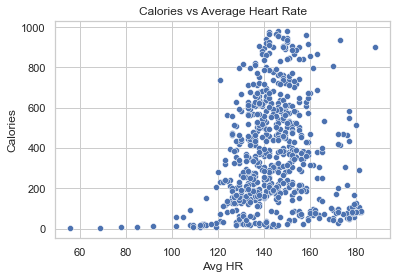

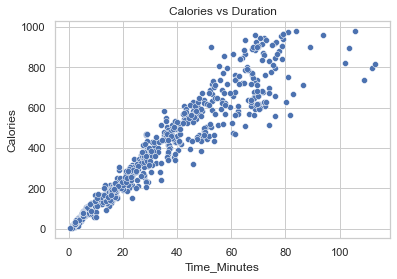

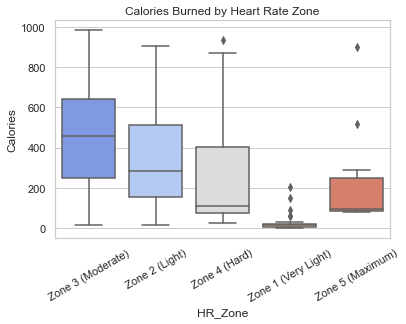

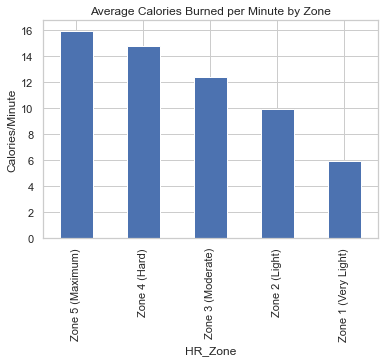

In [5]:
#Data Visualisations 
# Calories vs Avg HR
sns.scatterplot(data=df, x="Avg HR", y="Calories")
plt.title("Calories vs Average Heart Rate")
plt.show()

# Calories vs Duration
sns.scatterplot(data=df, x="Time_Minutes", y="Calories")
plt.title("Calories vs Duration")
plt.show()

# Boxplot: Calories per Heart Rate Zone
sns.boxplot(data=df, x="HR_Zone", y="Calories", palette="coolwarm")
plt.xticks(rotation=30)
plt.title("Calories Burned by Heart Rate Zone")
plt.show()

# Optional: Efficiency Analysis
df["Calories_per_minute"] = df["Calories"] / df["Time_Minutes"]
df.groupby("HR_Zone")["Calories_per_minute"].mean().sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Calories/Minute")
plt.title("Average Calories Burned per Minute by Zone")
plt.show()

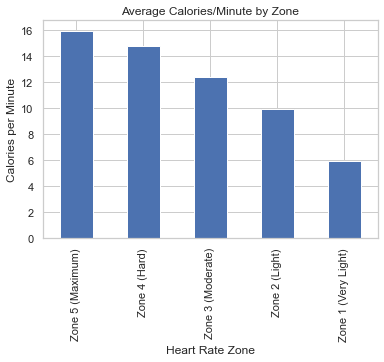

In [6]:
#New data visualisation of Average Calories vs Heart Rate Zone

#Calories per minute calculation
df["Calories_per_minute"] = df["Calories"] / df["Time_Minutes"]

#Plot zone efficency
zone_efficiency = df.groupby("HR_Zone")["Calories_per_minute"].mean().sort_values(ascending=False)
zone_efficiency.plot(kind='bar', title='Average Calories/Minute by Zone')
plt.ylabel("Calories per Minute")
plt.xlabel("Heart Rate Zone")
plt.show()

In [7]:
#Build and Evaluate Random Forest Predictive Model

# Encode HR Zones for machine learning
df_encoded = pd.get_dummies(df, columns=["HR_Zone"], drop_first=True)

# Select features and target
features = ['Time_Minutes', 'Avg HR'] + [col for col in df_encoded.columns if "HR_Zone_" in col]
X = df_encoded[features]
y = df_encoded["Calories"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print("Random Forest Model Performance:")
print("R² Score:", round(r2, 2))   # e.g., 0.85 means 85% of calorie variance is explained
print("RMSE:", round(rmse, 2))     # e.g., 45.12 means average prediction error is ~45 calories

Random Forest Model Performance:
R² Score: 0.98
RMSE: 32.92
